In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.preprocessing import LabelEncoder



In [2]:
# Parameters
input_size = (224, 224)
batch_size = 32
num_classes = 7  # Number of sentiment classes
epochs = 50  # Adjust as needed



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to preprocess the dataset with data augmentation
def preprocess_dataset(dataset_dir, input_size):
    data = []
    labels = []
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255
    )

    label_encoder = LabelEncoder()

    for emotion_label in os.listdir(dataset_dir):
        emotion_dir = os.path.join(dataset_dir, emotion_label)
        if os.path.isdir(emotion_dir):
            for root, dirs, files in os.walk(emotion_dir):
                for image_file in files:
                    image_path = os.path.join(root, image_file)
                    image = load_img(image_path, target_size=input_size)
                    image = img_to_array(image)
                    
                    if image.shape[-1] != 3:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image = cv2.equalizeHist(image)
                        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                    
                    data.append(image)
                    labels.append(emotion_label)

    labels = label_encoder.fit_transform(labels)
    return np.array(data), labels


In [4]:
from sklearn.model_selection import train_test_split
# Dataset
dataset_dir = 'D:/Study/Digital Image Processing/Dataset/KDEF'

input_size = (224, 224)

# Preprocess the Dataset
X, y = preprocess_dataset(dataset_dir, input_size)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)



In [188]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base models
vgg_base = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_size + (3,))


# for layer in vgg_base.layers:
#      layer.trainable = False

# for layer in vgg_base.layers:
#     print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

# # Freeze top layers in base models
def freeze_top_layers(base_model):
     for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
        layer.trainable = False

freeze_top_layers(vgg_base)

for layer in vgg_base.layers:
    print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

Layer Name: input_8, Trainable: False
Layer Name: block1_conv1, Trainable: False
Layer Name: block1_conv2, Trainable: False
Layer Name: block1_pool, Trainable: False
Layer Name: block2_conv1, Trainable: False
Layer Name: block2_conv2, Trainable: False
Layer Name: block2_pool, Trainable: False
Layer Name: block3_conv1, Trainable: False
Layer Name: block3_conv2, Trainable: False
Layer Name: block3_conv3, Trainable: False
Layer Name: block3_conv4, Trainable: False
Layer Name: block3_pool, Trainable: False
Layer Name: block4_conv1, Trainable: False
Layer Name: block4_conv2, Trainable: False
Layer Name: block4_conv3, Trainable: False
Layer Name: block4_conv4, Trainable: False
Layer Name: block4_pool, Trainable: False
Layer Name: block5_conv1, Trainable: False
Layer Name: block5_conv2, Trainable: True
Layer Name: block5_conv3, Trainable: True
Layer Name: block5_conv4, Trainable: True
Layer Name: block5_pool, Trainable: True


In [189]:
non_frozen_layers = [layer.name for layer in vgg_base.layers if layer.trainable]

print("Non-frozen layers:")
print(non_frozen_layers)

Non-frozen layers:
['block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


In [190]:
num_classes=7

In [191]:
# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, num_classes,dropout_rate=0.5,l2_penalty=0.01):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create transfer models with dropout
vgg_model_with_dropout = create_transfer_model_with_dropout(vgg_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(vgg_model_with_dropout)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Data generators for training and testing
#train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
#test_datagen = datagen.flow(X_test, y_test, batch_size=batch_size)

#Train the models
#vgg_history_with_dropout = vgg_model_with_dropout.fit(train_datagen, epochs=epochs, validation_data=test_datagen, callbacks=[early_stopping])

vgg_history_with_dropout = vgg_model_with_dropout.fit(X_train, y_train, 
                                                       batch_size= batch_size,
                                                       validation_data= (X_test,y_test),
                                                       validation_batch_size=batch_size,
                                                       epochs=epochs, 
                                                       callbacks=[early_stopping])




Epoch 1/50
74/74 [==============================] - 428s 6s/step - loss: 8.1604 - accuracy: 0.2298 - val_loss: 7.0596 - val_accuracy: 0.4456
Epoch 2/50
74/74 [==============================] - 425s 6s/step - loss: 6.4040 - accuracy: 0.4396 - val_loss: 5.6052 - val_accuracy: 0.5340
Epoch 3/50
74/74 [==============================] - 429s 6s/step - loss: 5.0202 - accuracy: 0.5847 - val_loss: 4.3432 - val_accuracy: 0.6735
Epoch 4/50
74/74 [==============================] - 430s 6s/step - loss: 3.9687 - accuracy: 0.6894 - val_loss: 3.4349 - val_accuracy: 0.7653
Epoch 5/50
74/74 [==============================] - 426s 6s/step - loss: 3.0998 - accuracy: 0.7800 - val_loss: 2.7519 - val_accuracy: 0.8214
Epoch 6/50
74/74 [==============================] - 431s 6s/step - loss: 2.4631 - accuracy: 0.8404 - val_loss: 2.4815 - val_accuracy: 0.7772
Epoch 7/50
74/74 [==============================] - 423s 6s/step - loss: 1.9423 - accuracy: 0.8898 - val_loss: 1.8262 - val_accuracy: 0.8656
Epoch 8/50
74

In [192]:
vgg_train_loss = vgg_history_with_dropout.history['loss']
vgg_val_loss = vgg_history_with_dropout.history['val_loss']
vgg_train_acc = vgg_history_with_dropout.history['accuracy']
vgg_val_acc = vgg_history_with_dropout.history['val_accuracy']

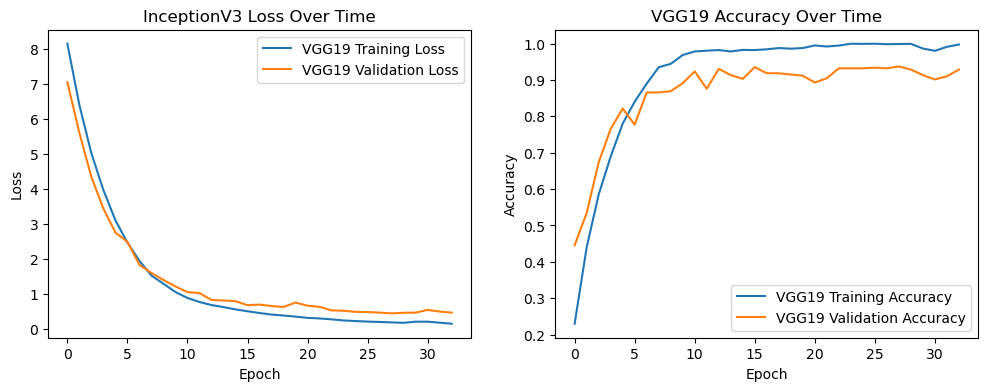

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_train_loss, label='VGG19 Training Loss')
plt.plot(vgg_val_loss, label='VGG19 Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('InceptionV3 Loss Over Time')

plt.subplot(1, 2, 2)
plt.plot(vgg_train_acc, label='VGG19 Training Accuracy')
plt.plot(vgg_val_acc, label='VGG19 Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG19 Accuracy Over Time')

plt.show()


In [194]:
train_accuracy = vgg_history_with_dropout.history['accuracy']
val_accuracy = vgg_history_with_dropout.history['val_accuracy']

print(f"Final Training Accuracy of VGG19: {train_accuracy[-1]}")
print(f"Final Validation Accuracy of VGG19: {val_accuracy[-1]}")


Final Training Accuracy of VGG19: 0.9974468350410461
Final Validation Accuracy of VGG19: 0.9285714030265808


In [195]:
from sklearn.metrics import classification_report

# Obtain predictions on test data
predictions = vgg_model_with_dropout.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class labels
true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes)
print(report)


19/19 [==============================] - 70s 4s/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94        90
           1       0.91      0.95      0.93        86
           2       0.93      0.83      0.88        90
           3       0.95      1.00      0.98        81
           4       0.92      0.95      0.93        80
           5       0.91      0.90      0.90        77
           6       0.95      0.93      0.94        84

    accuracy                           0.93       588
   macro avg       0.93      0.93      0.93       588
weighted avg       0.93      0.93      0.93       588



In [196]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions using your trained model on the test data
predictions = vgg_model_with_dropout.predict(X_test)
# predictions contain the predicted labels for the test images

# Convert predictions and true labels to categorical labels (if needed)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Assuming one-hot encoded labels for y_test

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


19/19 [==============================] - 68s 4s/step
Confusion Matrix:
[[85  1  0  0  4  0  0]
 [ 2 82  0  1  0  1  0]
 [ 0  4 75  2  1  4  4]
 [ 0  0  0 81  0  0  0]
 [ 2  0  0  0 76  2  0]
 [ 2  3  1  1  1 69  0]
 [ 0  0  5  0  1  0 78]]


# MobileNetV2

In [10]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load base models
MobileNetV2_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size + (3,))


for layer in MobileNetV2_base.layers:
     layer.trainable = False

# for layer in vgg_base.layers:
#     print(f"Layer Name: {layer.name}, Trainable: {layer.trainable}")

# # # Freeze top layers in base models
# def freeze_top_layers(base_model):
#      for layer in MobileNetV2_base.layers[:-4]:  # Freeze all layers except the last 4
#         layer.trainable = False

freeze_top_layers(MobileNetV2_base)

In [11]:
non_frozen_layers = [layer.name for layer in MobileNetV2_base.layers if layer.trainable]

print("Non-frozen layers:")
print(non_frozen_layers)

Non-frozen layers:
[]


In [12]:
# Function to create transfer model with dropout
def create_transfer_model_with_dropout(base_model, num_classes,dropout_rate=0.5,l2_penalty=0.01):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_penalty))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(7, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create transfer models with dropout
MobileNetv2_model_with_dropout = create_transfer_model_with_dropout(MobileNetV2_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

compile_model(MobileNetv2_model_with_dropout)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

MobileNetV2_history_with_dropout = MobileNetv2_model_with_dropout.fit(X_train, y_train, 
                                                       batch_size= batch_size,
                                                       validation_data= (X_test,y_test),
                                                       validation_batch_size=batch_size,
                                                       epochs=epochs, 
                                                       callbacks=[early_stopping])




Epoch 1/50
74/74 [==============================] - 51s 617ms/step - loss: 12.0904 - accuracy: 0.1255 - val_loss: 10.2747 - val_accuracy: 0.1837
Epoch 2/50
74/74 [==============================] - 40s 547ms/step - loss: 9.2921 - accuracy: 0.1834 - val_loss: 8.1291 - val_accuracy: 0.2296
Epoch 3/50
74/74 [==============================] - 41s 554ms/step - loss: 7.4430 - accuracy: 0.2149 - val_loss: 6.6489 - val_accuracy: 0.2755
Epoch 4/50
74/74 [==============================] - 41s 557ms/step - loss: 6.1511 - accuracy: 0.2357 - val_loss: 5.6476 - val_accuracy: 0.2602
Epoch 5/50
74/74 [==============================] - 42s 563ms/step - loss: 5.2556 - accuracy: 0.2498 - val_loss: 4.8939 - val_accuracy: 0.2534
Epoch 6/50
74/74 [==============================] - 41s 562ms/step - loss: 4.6361 - accuracy: 0.2528 - val_loss: 4.3533 - val_accuracy: 0.2925
Epoch 7/50
74/74 [==============================] - 42s 568ms/step - loss: 4.1865 - accuracy: 0.2749 - val_loss: 4.0144 - val_accuracy: 0.26